In [6]:
import torch
import numpy as np
from PIL import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image
from facenet_pytorch.models.mtcnn import PNet, RNet, ONet  # Import P-Net, R-Net, O-Net
from facenet_pytorch import MTCNN
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [7]:
match_images_folder = r'D:\Images\Facial_reco_images\Facial_reco_images\Game'  # match photos
studio_images_folder = r'D:\Images\Facial_reco_images\Facial_reco_images\Players\Studio_photos'  # studio photos

In [8]:
# 1. Define fine-tuned P-Net, R-Net, and O-Net for finetuning
class FinetunedMTCNN(MTCNN):
    def __init__(self, image_size=160, margin=15, **kwargs):
        super(FinetunedMTCNN, self).__init__(**kwargs)

        # Create your custom, finetuned P-Net, R-Net, O-Net here
        self.pnet = PNet()
        self.rnet = RNet()
        self.onet = ONet()

    def forward(self, x):
        # Overriding forward pass if additional finetuning is needed
        return super().forward(x)

In [9]:
finetuned_mtcnn = FinetunedMTCNN(keep_all=True, device='cuda:0' if torch.cuda.is_available() else 'cpu', min_face_size=60)


In [22]:
# 2. Function to align faces using landmarks
def align_face(image, landmarks, desired_size=(160, 160)):
    left_eye = landmarks[0, :2]
    right_eye = landmarks[1, :2]
    
    # Calculate the center point and angle for rotation
    eye_center = np.mean([left_eye, right_eye], axis=0)
    dx = right_eye[0] - left_eye[0]
    dy = right_eye[1] - left_eye[1]
    angle = np.arctan2(dy, dx) * (180.0 / np.pi)
    
    # Rotate the image to align eyes horizontally
    image = image.rotate(-angle, resample=Image.BICUBIC, expand=True)
    
    # Resize the aligned image to the desired size
    image = image.resize(desired_size, resample=Image.BICUBIC)
    
    return image


In [23]:
# 3. Function to perform face detection, apply NMS, and save cropped face images
def process_and_save_faces(image_folder, mtcnn_model):
    aligned_faces = []
    original_faces = []

    for filename in os.listdir(image_folder):
        if filename.endswith(".jpeg"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)

            # Detect faces (with bounding boxes, probabilities, and landmarks)
            boxes, probs, landmarks = mtcnn_model.detect(image, landmarks=True)
            
            if boxes is not None:
                # Set a confidence threshold
                threshold = 0.96

                # Filter detected faces based on the confidence score
                filtered_faces = [i for i, prob in enumerate(probs) if prob > threshold]

                # Save cropped faces that pass the confidence threshold
                for i in filtered_faces:
                    box = boxes[i]  # Get the bounding box for the filtered face
                    # Crop the face using the O-Net bounding box
                    cropped_face = image.crop(box)

                    # Save the original cropped face
                    original_faces.append(cropped_face)

                    # Align the face
                    aligned_face = align_face(cropped_face, landmarks[i])
                    aligned_faces.append(aligned_face)

                    # Save the cropped and aligned face image in the output folder
                    #face_output_path = os.path.join(output_folder, f'face_{filename}_{i}.jpeg')
                    #aligned_face.save(face_output_path)

                    # Stop if we've collected enough images for visualization
                    if len(original_faces) >= 30:
                        break

                # Stop if we've collected enough images for visualization
                if len(original_faces) >= 30:
                    break

    return original_faces, aligned_faces

In [26]:
original_faces, aligned_faces = process_and_save_faces(match_images_folder, finetuned_mtcnn)


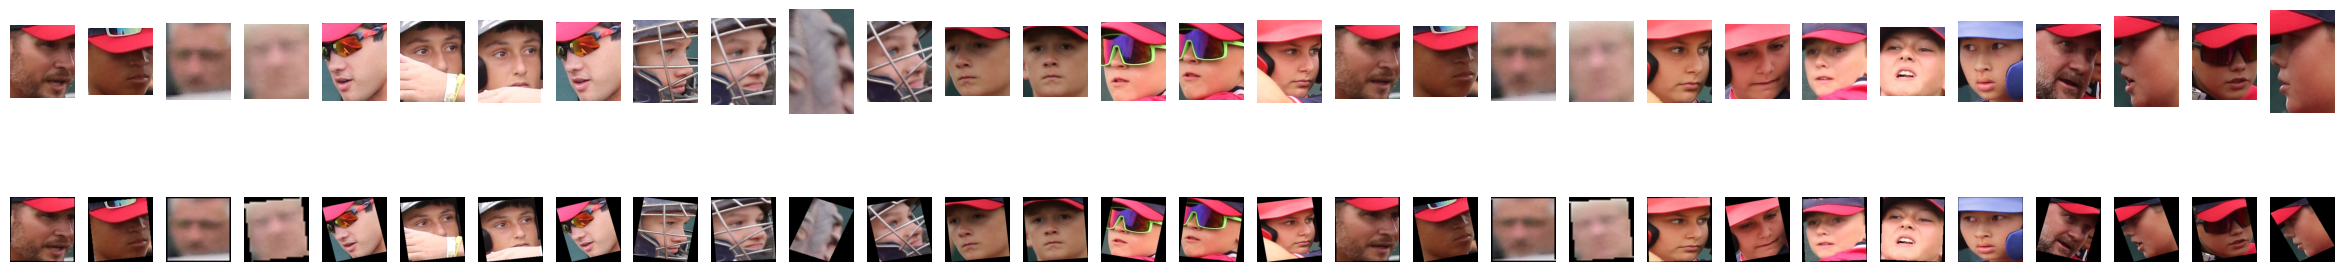

In [27]:
# 4. Visualize the original and aligned faces
def visualize_faces(original_faces, aligned_faces):
    fig, axs = plt.subplots(2, 30, figsize=(30, 4))
    for i in range(min(len(original_faces), 30)):
        axs[0, i].imshow(original_faces[i])
        axs[0, i].axis('off')
        axs[1, i].imshow(aligned_faces[i])
        axs[1, i].axis('off')
    axs[0, 0].set_ylabel('Original Faces')
    axs[1, 0].set_ylabel('Aligned Faces')
    plt.show()

visualize_faces(original_faces, aligned_faces)